In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
import numpy as np
import json
import requests
import pandas as pd


In [68]:
def make_data():
    data = json.loads(open('StockPredictionWithSentiment-master\StockPredictionWithSentiment-master\data\dataGot.json','r').read())
    senti = np.array(pd.read_csv('StockPredictionWithSentiment-master\StockPredictionWithSentiment-master\data\generatedscores.csv').get(['positive','negative']))
    embeddings = json.loads(open('StockPredictionWithSentiment-master\StockPredictionWithSentiment-master\data\generatedscores.json','r').read())["l"]
    print (embeddings[0])
    y = np.array(data['close'])
    print (len(y))
    X_relevant = np.array([[data['vol'][i],data['open'][i],data['low'][i],data['high'][i]] for i in range(len(y))])
    X = []
    max_price = -1
    min_price = 10000
    for i in range(len(X_relevant)-1, -1, -1):
        x_t = []
        x_t.append(X_relevant[i][0])
        x_t.append(X_relevant[i][1])
        x_t.append(X_relevant[i][2])
        x_t.append(X_relevant[i][3])
        max_price = max(y[i], max_price)
        x_t.append(max_price)
        min_price = min(y[i], min_price)
        x_t.append(min_price)
        x_t.append(senti[i][0])
        x_t.append(senti[i][1])
        x_t += embeddings[i]
        X.append(x_t)

    X = np.array(X)
    print (X.shape)
    X = X.reshape(X.shape[0],1,X.shape[1])
    data = {}
    data["X"] = X.tolist()
    data["y"] = y.tolist()
    json.dump(data,open('StockPredictionWithSentiment-master\StockPredictionWithSentiment-master\data\data_senti_word.json','w'))

def get_stock_data():
    link = 'https://query1.finance.yahoo.com/v8/finance/chart/GOOG?range=1d&includePrePost=false&interval=2m&corsDomain=in.finance.yahoo.com&.tsrc=finance'
    resp = requests.get(link)
    data = json.loads(resp.text)
    data = data['chart']['result'][0]['indicators']['quote'][0]
    volume = data['volume']
    close = data['close']
    low = data['low']
    high = data['high']
    open_val = data['open']
    json.dump(dict(vol=volume,close=close,low=low,high=high,open=open_val), open('StockPredictionWithSentiment-master\StockPredictionWithSentiment-master\data\dataGot.json','w'))


In [69]:
make_data()

[3.5214558874658737, 4.160007619880903, -2.462391028049016, 0.8423823547034832, -2.3681709840073966, 0.7439448283662721, -0.7937197738943935, 0.5056256880112864, 1.1019781668815616, -1.932103215219536, -1.859200947904223, -0.41707626120627467, -1.2385941356441348, -0.19934147365544458, 1.936804931126515, 1.6956932069827813, -1.8282729236121473, -0.35000214306335264, 1.0249365840683735, -0.20190506419114848, -2.1776967363278845, 0.7155541043760845, -0.32117113791542895, 0.30396158434181847, -3.1678567704936813, -0.9089307962069462, 1.143431908450517, 1.0939760565432528, -1.0848390178991454, -1.063613735397399, -1.510212488196962, 3.1281199438032434, -0.44362801282356185, 1.0284306195619668, -0.680455551175992, 3.1557738749366817, -2.2919287137273283, 0.33510698186504767, 1.2138662924465937, -3.757428426826359, -0.8921542799770213, 2.9172842787191655, -1.4592917138793942, -1.3870976336796272, -1.2343227644928048, -1.5281199888617853, 3.384722481284178, 0.9661484174204427, -1.114729940418

In [70]:
data = json.load(open("StockPredictionWithSentiment-master\StockPredictionWithSentiment-master\data\data_senti_word.json","rb"))
X_train = np.array(data['X'])
y_train = np.array(data['y']).reshape(-1,1)


In [71]:
epochs = 500
num_hidden = 20
data_dim = 58
batch_size=1
meen = np.mean(X_train.reshape(X_train.shape[0],-1),axis=0)
std = np.std(X_train.reshape(X_train.shape[0],-1),axis=0)
X_train -= meen
X_train /= std

In [39]:
model = Sequential()
model.add(LSTM(num_hidden, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size,1,data_dim)))
model.add(LSTM(num_hidden, return_sequences=True, stateful=True))
model.add(Flatten())
model.add(Dense(1))

In [40]:
model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])


In [41]:
# x_train = np.random.rand(64,1,6)
# x_test = np.random.rand(64,1,6)
# y_train = np.random.rand(64,)
# y_test = np.random.rand(64,)
accs = []
for e in range(epochs):
    print("EPOCH: "+str(e))
    history = model.fit(X_train, y_train,
              batch_size=batch_size, epochs=1, shuffle=False)
    accs.append(history.history['mean_absolute_error'])
    model.reset_states()


EPOCH: 0
Epoch 1/1
195/195 [==============================] - 11s 55ms/step - loss: 1040758.1304 - mean_absolute_error: 1020.1742
EPOCH: 1
Epoch 1/1
195/195 [==============================] - 3s 14ms/step - loss: 1031078.0224 - mean_absolute_error: 1015.4175
EPOCH: 2
Epoch 1/1
195/195 [==============================] - 3s 13ms/step - loss: 1022820.6849 - mean_absolute_error: 1011.3432
EPOCH: 3
Epoch 1/1
195/195 [==============================] - 2s 10ms/step - loss: 1014600.8324 - mean_absolute_error: 1007.2709
EPOCH: 4
Epoch 1/1
195/195 [==============================] - 2s 10ms/step - loss: 1006398.2663 - mean_absolute_error: 1003.1908
EPOCH: 5
Epoch 1/1
195/195 [==============================] - 1s 8ms/step - loss: 998227.5599 - mean_absolute_error: 999.1099
EPOCH: 6
Epoch 1/1
195/195 [==============================] - 1s 8ms/step - loss: 990082.8702 - mean_absolute_error: 995.0254
EPOCH: 7
Epoch 1/1
195/195 [==============================] - 1s 7ms/step - loss: 981956.1301 - mean_a

195/195 [==============================] - 2s 11ms/step - loss: 574308.2035 - mean_absolute_error: 757.8169
EPOCH: 65
Epoch 1/1
195/195 [==============================] - 2s 12ms/step - loss: 568129.5119 - mean_absolute_error: 753.7289
EPOCH: 66
Epoch 1/1
195/195 [==============================] - 3s 14ms/step - loss: 561984.2109 - mean_absolute_error: 749.6408
EPOCH: 67
Epoch 1/1
195/195 [==============================] - 2s 13ms/step - loss: 555872.3324 - mean_absolute_error: 745.5528
EPOCH: 68
Epoch 1/1
195/195 [==============================] - 3s 13ms/step - loss: 549793.8397 - mean_absolute_error: 741.4647
EPOCH: 69
Epoch 1/1
195/195 [==============================] - 2s 12ms/step - loss: 543748.8096 - mean_absolute_error: 737.3766
EPOCH: 70
Epoch 1/1
195/195 [==============================] - 2s 11ms/step - loss: 537737.1965 - mean_absolute_error: 733.2885
EPOCH: 71
Epoch 1/1
195/195 [==============================] - 3s 13ms/step - loss: 531758.9753 - mean_absolute_error: 729.2

195/195 [==============================] - 4s 19ms/step - loss: 69449.7054 - mean_absolute_error: 263.2416
EPOCH: 186
Epoch 1/1
195/195 [==============================] - 4s 20ms/step - loss: 67317.2702 - mean_absolute_error: 259.1564
EPOCH: 187
Epoch 1/1
195/195 [==============================] - 4s 20ms/step - loss: 65218.3703 - mean_absolute_error: 255.0716
EPOCH: 188
Epoch 1/1
195/195 [==============================] - 7s 35ms/step - loss: 63152.9813 - mean_absolute_error: 250.9870: 1s - los
EPOCH: 189
Epoch 1/1
195/195 [==============================] - 6s 29ms/step - loss: 61120.8715 - mean_absolute_error: 246.9022
EPOCH: 190
Epoch 1/1
195/195 [==============================] - 4s 20ms/step - loss: 59122.2788 - mean_absolute_error: 242.8177
EPOCH: 191
Epoch 1/1
195/195 [==============================] - 4s 20ms/step - loss: 57157.1122 - mean_absolute_error: 238.7333
EPOCH: 192
Epoch 1/1
195/195 [==============================] - 4s 19ms/step - loss: 55225.4139 - mean_absolute_err

195/195 [==============================] - 2s 9ms/step - loss: 281.2528 - mean_absolute_error: 4.5775
EPOCH: 313
Epoch 1/1
195/195 [==============================] - 2s 8ms/step - loss: 281.2502 - mean_absolute_error: 4.5775
EPOCH: 314
Epoch 1/1
195/195 [==============================] - 2s 8ms/step - loss: 281.2481 - mean_absolute_error: 4.5775
EPOCH: 315
Epoch 1/1
195/195 [==============================] - 1s 7ms/step - loss: 281.2457 - mean_absolute_error: 4.5775
EPOCH: 316
Epoch 1/1
195/195 [==============================] - 1s 8ms/step - loss: 281.2430 - mean_absolute_error: 4.5775
EPOCH: 317
Epoch 1/1
195/195 [==============================] - 1s 7ms/step - loss: 281.2409 - mean_absolute_error: 4.5775
EPOCH: 318
Epoch 1/1
195/195 [==============================] - 1s 7ms/step - loss: 281.2384 - mean_absolute_error: 4.5774- ETA: 1s - loss: 3708.4971 - m
EPOCH: 319
Epoch 1/1
195/195 [==============================] - 1s 7ms/step - loss: 281.2359 - mean_absolute_error: 4.5774
EPOCH:

195/195 [==============================] - 2s 9ms/step - loss: 280.9298 - mean_absolute_error: 4.5766
EPOCH: 445
Epoch 1/1
195/195 [==============================] - 2s 9ms/step - loss: 280.9279 - mean_absolute_error: 4.5766
EPOCH: 446
Epoch 1/1
195/195 [==============================] - 2s 9ms/step - loss: 280.9252 - mean_absolute_error: 4.5766
EPOCH: 447
Epoch 1/1
195/195 [==============================] - 2s 9ms/step - loss: 280.9228 - mean_absolute_error: 4.5766
EPOCH: 448
Epoch 1/1
195/195 [==============================] - 2s 9ms/step - loss: 280.9199 - mean_absolute_error: 4.5766
EPOCH: 449
Epoch 1/1
195/195 [==============================] - 2s 9ms/step - loss: 280.9178 - mean_absolute_error: 4.5766
EPOCH: 450
Epoch 1/1
195/195 [==============================] - 2s 9ms/step - loss: 280.9149 - mean_absolute_error: 4.5765
EPOCH: 451
Epoch 1/1
195/195 [==============================] - 2s 9ms/step - loss: 280.9129 - mean_absolute_error: 4.5766
EPOCH: 452
Epoch 1/1
195/195 [=======

In [47]:
model.save('lstm-senti-word2.h5')
# for k in range(x_test.shape[0]):
#     y_pred = model.predict(x_test[k].reshape(1,1,-1))
#     print(y_pred)
data["mean"]=meen.tolist()
data["std"]=std.tolist()
data['acc']=accs


In [48]:
type(data)

dict

In [51]:
json.dump(data,open("StockPredictionWithSentiment-master\StockPredictionWithSentiment-master\data\data2-senti-word2.json","w"))

In [52]:
import matplotlib.pyplot as plt

In [54]:
data = json.loads(open('StockPredictionWithSentiment-master\StockPredictionWithSentiment-master\saved_params\data2.json','r').read())
data_normal  = np.array(data['acc']).flatten()

In [59]:
data = json.loads(open('StockPredictionWithSentiment-master\StockPredictionWithSentiment-master\saved_params\data2-senti2.json','r').read())
data_senti  = np.array(data['acc']).flatten()

data = json.loads(open('StockPredictionWithSentiment-master\StockPredictionWithSentiment-master\saved_params\data2-senti-word2.json','r').read())
data_senti_word  = np.array(data['acc']).flatten()

In [60]:
epochs = [i for i in range(len(data_normal))]

In [64]:
line_normal,  = plt.plot(epochs, data_normal, 'b', label='Without Sentiment, mae: '+str(round(data_normal[-1])))
line_senti, = plt.plot(epochs, data_senti, 'g', label='With Sentiment, mae: '+str(round(data_senti[-1])))
line_senti_word, = plt.plot(epochs, data_senti_word, 'r', label='Sentiment+Word2Vec, mae: '+str(round(data_senti_word[-1])))

In [66]:
plt.legend(handles=[line_normal, line_senti, line_senti_word])
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')

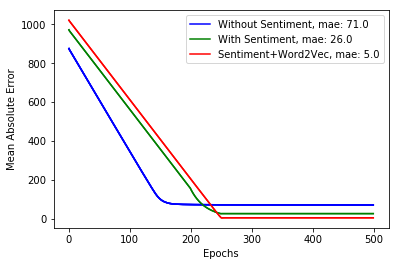

In [67]:
plt.show()